# Tweety powiązane z koronawirusem

autor prezentacji: Mateusz Szybiak, Informatyka niestacjonarnie, semestr II, stopień II

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.preprocessing import normalize
from utils import *

In [2]:
df = pd.read_csv(r"Corona_NLP.csv")
df["Sentiment"] = df["Sentiment"].apply(lambda x: apply_positive_negative(x))
df = df[:30000]
df

,Unnamed: 0,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Negative
1,1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Positive
3,3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...,...
29995,26197,29996,74948,Masshole,02-04-2020,Spike in demand at food banks across country a...,Negative
29996,26198,29997,74949,The Kitchen As Always.,02-04-2020,"Dear Grocery Industries,\r\r\n\r\r\nSTOP clogg...",Positive
29997,26199,29998,74950,NaN,02-04-2020,The outlook for the EMEA unregulated amp utili...,Positive
29998,26200,29999,74951,NaN,02-04-2020,Pay close attention to corporations during and...,Negative


Positive

In [3]:
df['OriginalTweet'][1]

"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how  #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY"

Negative

In [4]:
df['OriginalTweet'][0]

'TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1'

Neutral

In [5]:
df[df['Sentiment'] == 'Neutral']['OriginalTweet'][7]

'@DrTedros "We can\x92t stop #COVID19 without protecting #healthworkers.\r\r\nPrices of surgical masks have increased six-fold, N95 respirators have more than trebled &amp; gowns cost twice as much"-@DrTedros #coronavirus'

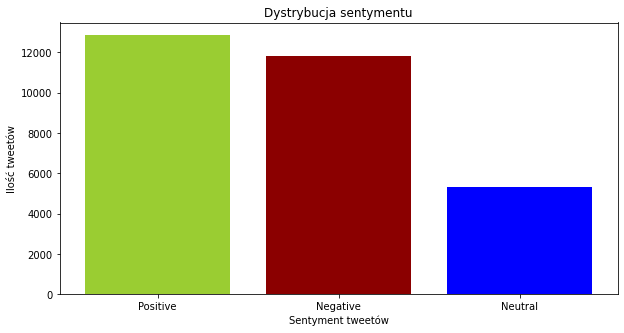

In [6]:
plot(df)

In [7]:
df["Sentiment"].value_counts()

Positive    12846
Negative    11810
Neutral      5344
Name: Sentiment, dtype: int64

In [8]:
string = ""
for i in tqdm(range(len(df['OriginalTweet']))):
    string += df['OriginalTweet'].iloc[i] + " "
len(string)
stemmed_text = stemming(remove_stop_words(cleaning_text(string).split()))
bow = bag_of_words(stemmed_text)

100%|█████████████████████████████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 19993.51it/s]


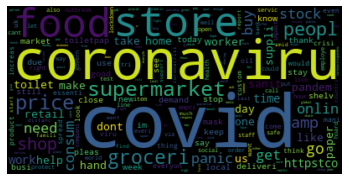

In [9]:
wordcloud(bow)

In [10]:
vectorizer = CountVectorizer(tokenizer=text_tokenizer)
X_transform = vectorizer.fit_transform(df['OriginalTweet'])

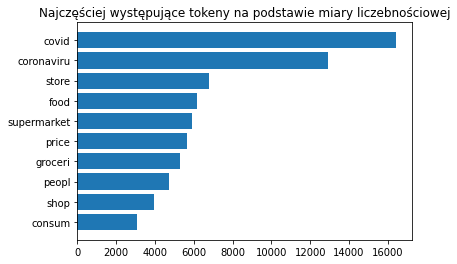

In [11]:
plot_most_important(top_tokens(X_transform.toarray().sum(axis=0), vectorizer.get_feature_names_out(), 10),
                    bow, "Najczęściej występujące tokeny na podstawie miary liczebnościowej")

In [12]:
pretty_table_most_important(top_tokens(X_transform.toarray().sum(axis=0), vectorizer.get_feature_names_out(), 10),
                            bow, "Najczęściej występujące tokeny na podstawie miary liczebnościowej")

+--------------------------------------------------------+
| Najczęściej występujące tokeny na podstawie miary liczebnościowej |
+-------------------------------------+------------------+
|                 Term                |      Count       |
+-------------------------------------+------------------+
|                covid                |      16440       |
|              coronaviru             |      12897       |
|                store                |       6768       |
|                 food                |       6183       |
|             supermarket             |       5899       |
|                price                |       5647       |
|               groceri               |       5309       |
|                peopl                |       4706       |
|                 shop                |       3953       |
|                consum               |       3045       |
+-------------------------------------+------------------+


In [13]:
vectorizer_tfidf = TfidfVectorizer(tokenizer=text_tokenizer)
transform_tfidf = vectorizer_tfidf.fit_transform(df['OriginalTweet'])
columns = vectorizer_tfidf.get_feature_names_out()
weights = transform_tfidf.toarray().mean(axis=0)

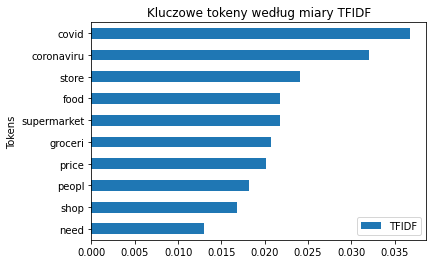

In [14]:
key_plot(columns, weights)

In [15]:
pretty_table_key(columns, weights)

+--------------------------------------+
|  Kluczowe tokeny według miary TFIDF  |
+--------------+-----------------------+
|     Term     |         Weight        |
+--------------+-----------------------+
|    covid     |  0.03679373597272757  |
|  coronaviru  |  0.032020480323821765 |
|    store     |  0.024040957915554266 |
|     food     |  0.021812829604196646 |
| supermarket  |  0.021710505455019766 |
|   groceri    |  0.020667978606601096 |
|    price     |  0.020151168127338335 |
|    peopl     |  0.01812473872487658  |
|     shop     |  0.01676549332898863  |
|     need     |  0.012957649518533659 |
+--------------+-----------------------+


In [16]:
x_train, x_test, y_train, y_test = train_test_split(X_transform, df['Sentiment'], test_size=0.3, random_state=42)

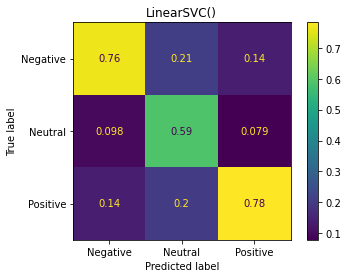

              precision    recall  f1-score   support

    Negative       0.76      0.75      0.76      3546
     Neutral       0.59      0.59      0.59      1601
    Positive       0.78      0.79      0.79      3853

    accuracy                           0.74      9000
   macro avg       0.71      0.71      0.71      9000
weighted avg       0.74      0.74      0.74      9000



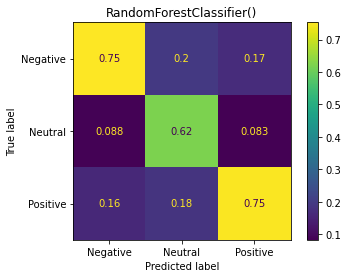

              precision    recall  f1-score   support

    Negative       0.75      0.72      0.74      3546
     Neutral       0.62      0.60      0.61      1601
    Positive       0.75      0.79      0.77      3853

    accuracy                           0.73      9000
   macro avg       0.71      0.70      0.71      9000
weighted avg       0.73      0.73      0.73      9000



In [17]:
classifiers = [LinearSVC(), RandomForestClassifier()]
for clf in classifiers:
    fig, ax = plt.subplots(1,1)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    cm = normalize(cm, axis=0, norm='l1')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    ax.title.set_text(f"{clf}")
    disp.plot(ax=ax)
    plt.show()
    cr = classification_report(y_test, y_pred, target_names=clf.classes_)
    print(cr)
   

### Interpretacja metryk RandomTreeClassifier()

Accuracy dla modelu wynosi 0.73. To oznacza, że 73% przypadków predykcji zostało zaklasyfikowanych zgodnie z prawdziwą klasą. 

Rozpatrując konkretne klasy:

Precision w przypadku Negative wynosi 0.75, czyli 75% klasyfikacji jako negative zostało wykonanych prawidłowo.

Recall w przypadku Negative wynosi 0.72, czyli spośród wszystkich przypadków negative, 72% zostało przewidzianych prawidłowo.

F1-score jest sumą ważoną precision i recall, w przypadku negative wynosi 0.73. Interpretacja w przypadku pozostałych klas jest analogiczna.